# Content 

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. In this notebook, we use optuna and fbprophet for forecasting. The objective here is, forecasting the growth of the e-commerce market in United Kingdom.

**1.Part:** Analyze and Clean the Dataset

**2.Part:** Hyperparameter Tuning with Optuna

**3.Part:** Scores of Fbprophet

## 1. Analyze and Clean the Dataset

In this notebook, we only work with United Kingdom. So firstly, we filter the Country. Then we check for missing value and there are missing values in dataset. But there is no missing value in Quantity and UnitPrice columns that we interest in. Therefore, we don't need for missing value handling. Thirdly, there are outliers in the dataset. These outliers have bad effects on forecasting. That is why we filter the total_price column between -2000 and 20000.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.simplefilter("ignore")
data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [3]:
data_UK = data[data['Country'] == 'United Kingdom']
data_UK['total_price'] = data_UK['Quantity'] * data_UK['UnitPrice']
data_UK['InvoiceDate'] = pd.to_datetime(data_UK['InvoiceDate'])
data_UK['InvoiceDate_15m'] = data_UK['InvoiceDate'].dt.round('15min')
data_UK['InvoiceDate_1h'] = data_UK['InvoiceDate'].dt.round('1h')

In [4]:
data_UK.isna().sum()

InvoiceNo               0
StockCode               0
Description          1454
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID         133600
Country                 0
total_price             0
InvoiceDate_15m         0
InvoiceDate_1h          0
dtype: int64

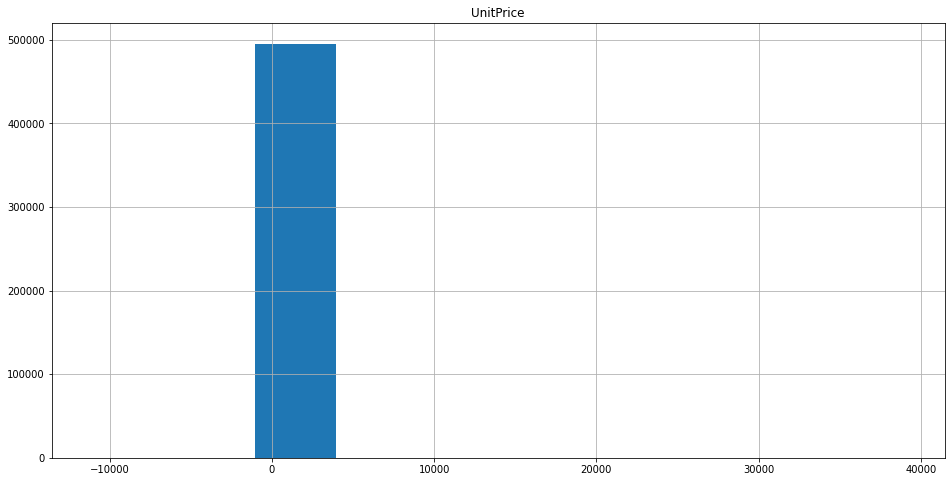

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('UnitPrice', ax=ax);

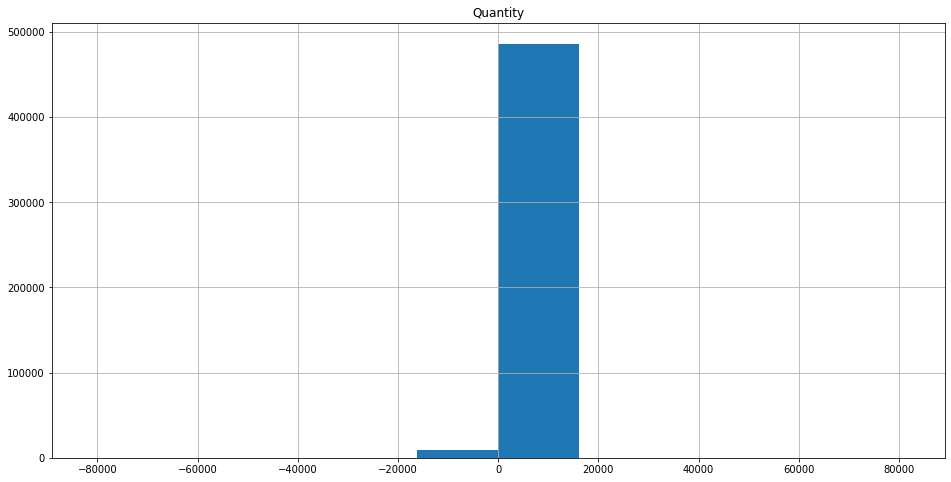

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('Quantity', ax=ax);

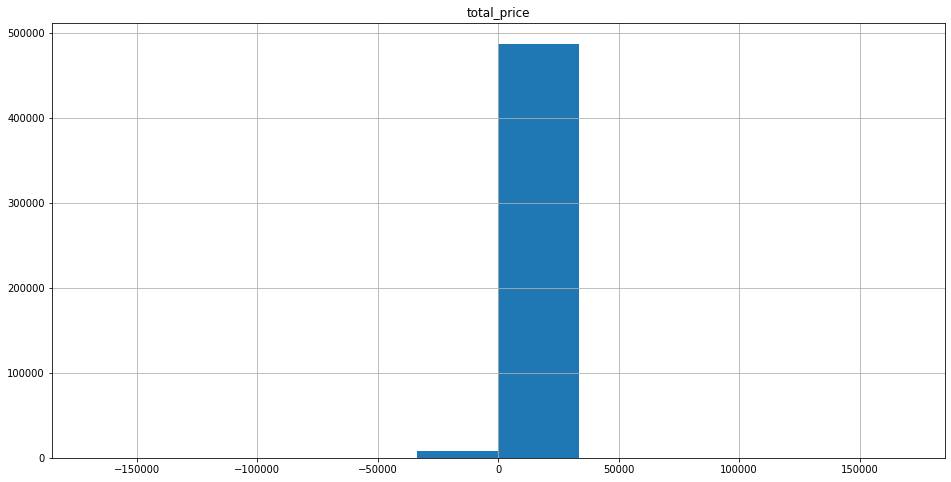

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('total_price', ax=ax);

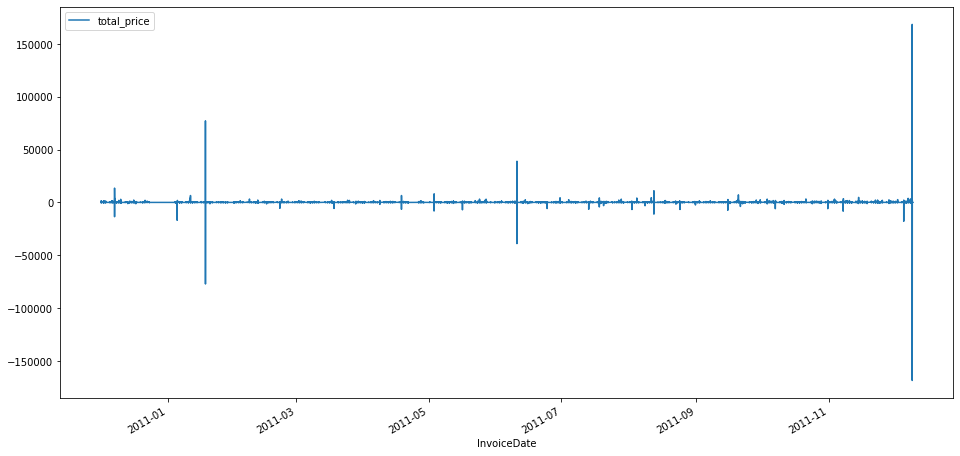

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

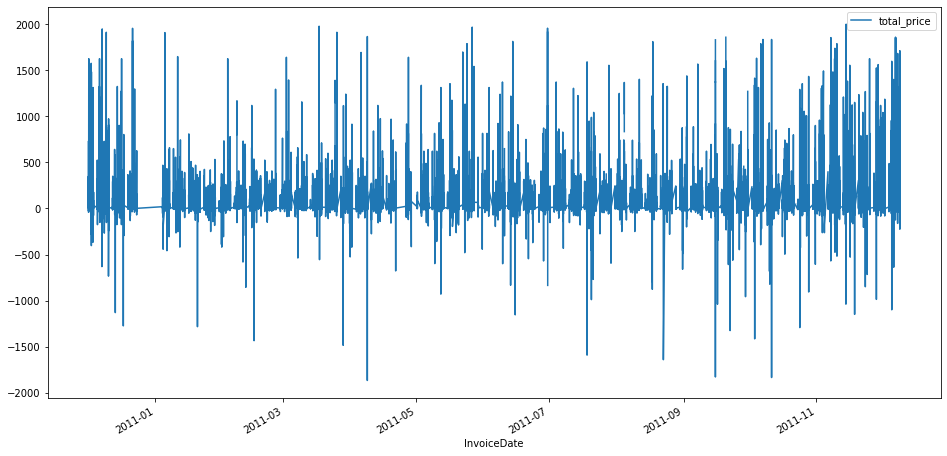

In [9]:
#data_UK = data_UK[(data_UK['total_price'] < 25000) & (data_UK['total_price'] > -25000)]
data_UK.loc[(data_UK['total_price'] > 2000) | (data_UK['total_price'] < -2000), 'total_price'] = None
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

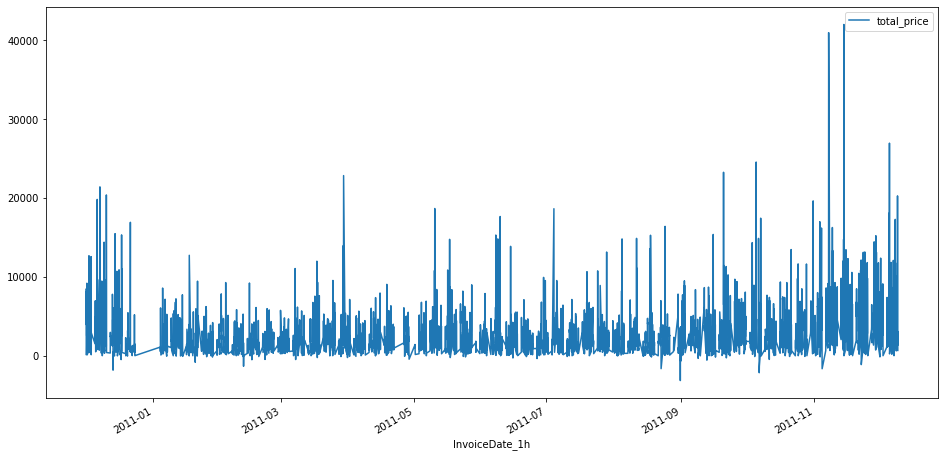

In [10]:
data_UK_1h = data_UK.groupby('InvoiceDate_1h').agg({'total_price':'sum'})
fig, ax = plt.subplots(figsize=(16, 8))
data_UK_1h.plot(y='total_price', ax=ax);

In [11]:
t = np.arange(data_UK_1h.index[0], data_UK_1h.index[-1] + timedelta(hours=1), timedelta(hours=1)).astype(datetime)
train_test = pd.DataFrame()
train_test['ds'] = pd.to_datetime(t)
train_test['y'] = 0
train_test['cap'] = 20000
train_test['floor'] = -2000
train_test.iloc[train_test['ds'].isin(data_UK_1h.index), 1] = data_UK_1h['total_price']
train_test.shape

(8958, 4)

## 2. Hyperparameter Tuning with Optuna

Hyperparameter tuning is the problem of selecting a set of optimal hyperparameters for a machine learning algorithm. Every machine learing algorithm has different parameters and these parameters can change according to problem and dataset.

Optuna is the most popular hyperparameter tuning technique. You can see the usage optuna for fbprophet in the below.

In [12]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


test_size = int(train_test.shape[0] / 10)
train_df = train_test.iloc[:-test_size, :]
val_df = train_test.iloc[-test_size:int(-test_size/2), :]
test_df = train_test.iloc[int(-test_size/2):, :]

In [13]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train_df)
    preds = m.predict(val_df[['ds', 'cap', 'floor']])
    
    mae_score = mean_absolute_error(val_df['y'], preds['yhat'])
    return mae_score

In [14]:
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=1000)

#study.best_params

In [15]:
params = {
     'changepoint_prior_scale': 3.391667952710346,
     'changepoint_range': 0.8397114666270911,
     'seasonality_prior_scale': 3.6115808925351867,
     'holidays_prior_scale': 4.845991897188627,
     'seasonality_mode': 'multiplicative',
     'growth': 'linear',
     'weekly_seasonality': 10,
     'yearly_seasonality': 3
}

## 3. Scores of Fbprophet

Mean absolute error metric is better than mean squared error when dataset has outlier. That is why we use MAE. R2 metric is used for understanding randomness of predictions. If the model always predicts mean value, r2 score will be 0.

In [16]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)
    
    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }
    
    return report_dict

In [17]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')

concat_train_df = pd.concat([train_df, val_df])
m.fit(concat_train_df)
preds = m.predict(test_df[['ds', 'cap', 'floor']])
result = regression_report(test_df['y'], preds['yhat'])

Initial log joint probability = -14.0374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23462.7     0.0156343        3442.2      0.6903     0.06903      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23604.4     0.0073288       1323.88      0.7989      0.7989      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23636.9    0.00553732       2036.85      0.9353      0.9353      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23661.6    0.00497328       2216.55       0.543       0.543      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       23668.8   0.000777185       141.965           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [18]:
result

{'mae_score': 1333.9556232410328,
 'mse_score': 6747670.311778453,
 'r2_score': 0.48140082967636566}

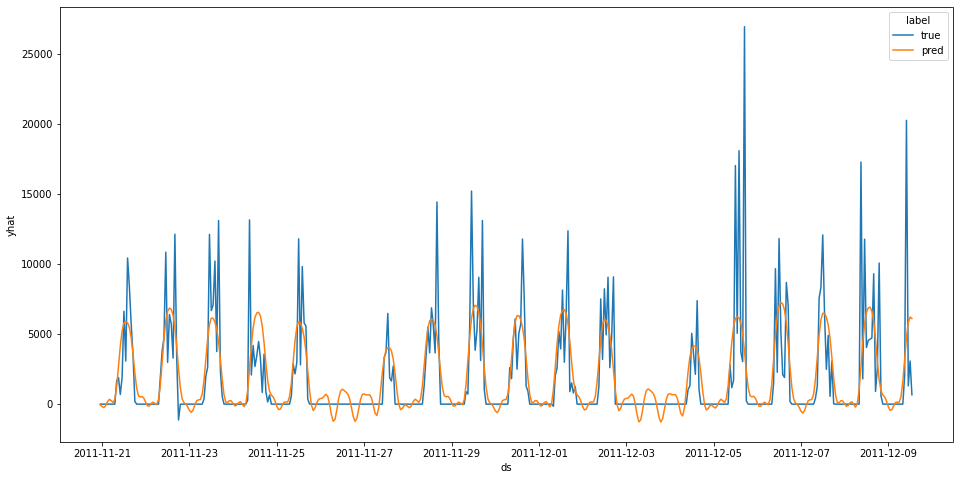

In [19]:
pd.options.mode.chained_assignment = None
test_df.loc[:, 'label'] = 'true'
test_df.loc[:, 'yhat'] = test_df.loc[:, 'y']
preds.loc[:, 'label'] = 'pred'
df_result = pd.concat([test_df[['yhat', 'label', 'ds']], preds[['yhat', 'label', 'ds']]])
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(y='yhat', x='ds', ax=ax, data=df_result, hue='label', markers=True)
plt.show()